# Post Processing Notebook

Let's use this notebook to organise and run our post-processing of the data.

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import rebound

%config InlineBackend.figure_format = 'retina'

In [2]:
# Simulations Folder
# folder = '../data/simulations/2018-11-21_21-09-52/'
# folder = '../data/simulations/from_vm'
folder = '../data/simulations/2018-11-23_01-09-31-1e6'

In [3]:
f = open('../data/simulations/2018-11-23_01-09-31/sim_archive.bin')

In [4]:
sims = rebound.SimulationArchive(os.path.join(folder, 'sim_archive.bin'))
planets = pd.read_csv(os.path.join(folder, 'init', 'planets.csv'))
particles_init = pd.read_csv(os.path.join(folder, 'init', 'particles.csv'))
num_planets = len(planets)
post_folder = os.path.join(folder, 'post')

/home/alexk/.local/lib/python3.5/site-packages/rebound/simulationarchive.py:83: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)


## Sort the Units

In [5]:
M_DIM = 1.989e30 # kg
T_DIM = 1 / (2*np.pi) # years
D_DIM = 1.496e11 # m

M_DIM, T_DIM, D_DIM

(1.989e+30, 0.15915494309189535, 149600000000.0)

In [6]:
t = np.array([s.t for s in sims]) * T_DIM

/home/alexk/.local/lib/python3.5/site-packages/rebound/simulationarchive.py:127: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/home/alexk/.local/lib/python3.5/site-packages/rebound/simulationarchive.py:127: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


In [7]:
'{} Simulations ending {} years ({} units)'.format(len(t), t[-1], round(sims[-1].t))

'145 Simulations ending 159154.94319440678 years (1000000 units)'

## Density of Test Particles
We work out the radial density and radial counts. 

In [8]:
dr = 0.1

In [9]:
particles = sims[-1].particles
coords = pd.DataFrame(np.array([[p.hash.value, p.x, p.y, p.z] for p in particles]), columns=['id', 'x', 'y', 'z'])

coords['r'] = np.sqrt(coords.x**2 + coords.y**2)

r = np.linspace(dr, 10, 10 / dr)
radial_count = np.zeros_like(r)
for i, r_i in enumerate(r):
    radial_count[i] = len(coords.r[(coords.r > r_i) & (coords.r < r_i + dr)])
    
df_rad_density = pd.DataFrame({'r': r, 'radial_count': radial_count, 'radial_density': radial_count/(2*np.pi*r)})

/home/alexk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


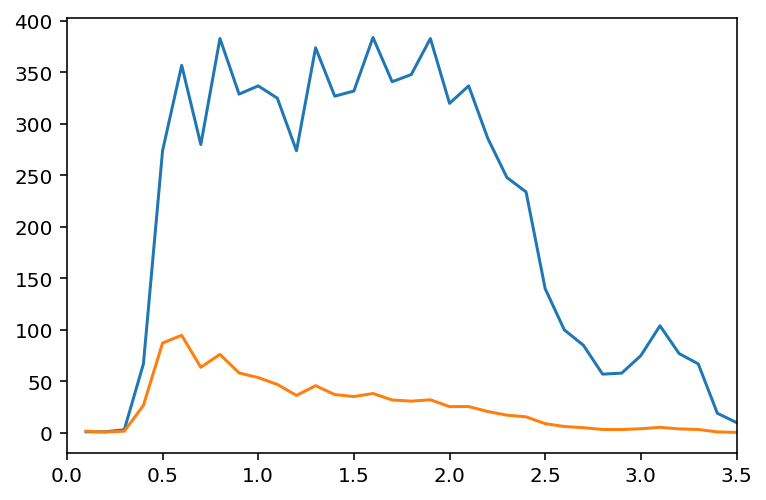

In [10]:
plt.plot(df_rad_density.r, df_rad_density.radial_count)
plt.plot(df_rad_density.r, df_rad_density.radial_density)
plt.xlim([0, 3.5])
plt.show()

## Particle Positions

In [16]:
sim = sims[-1]
sim.integrator_synchronize()

particles = sim.particles
parts = pd.DataFrame(np.array([[p.hash.value, p.x, p.y, p.z, p.e] for p in particles[1:]]), columns=['id', 'x', 'y', 'z', 'e'])

In [17]:
idx = (np.abs(parts.x) < 4) & (np.abs(parts.y) < 4) & (parts.e < 0.1)
len(parts[idx])

6205

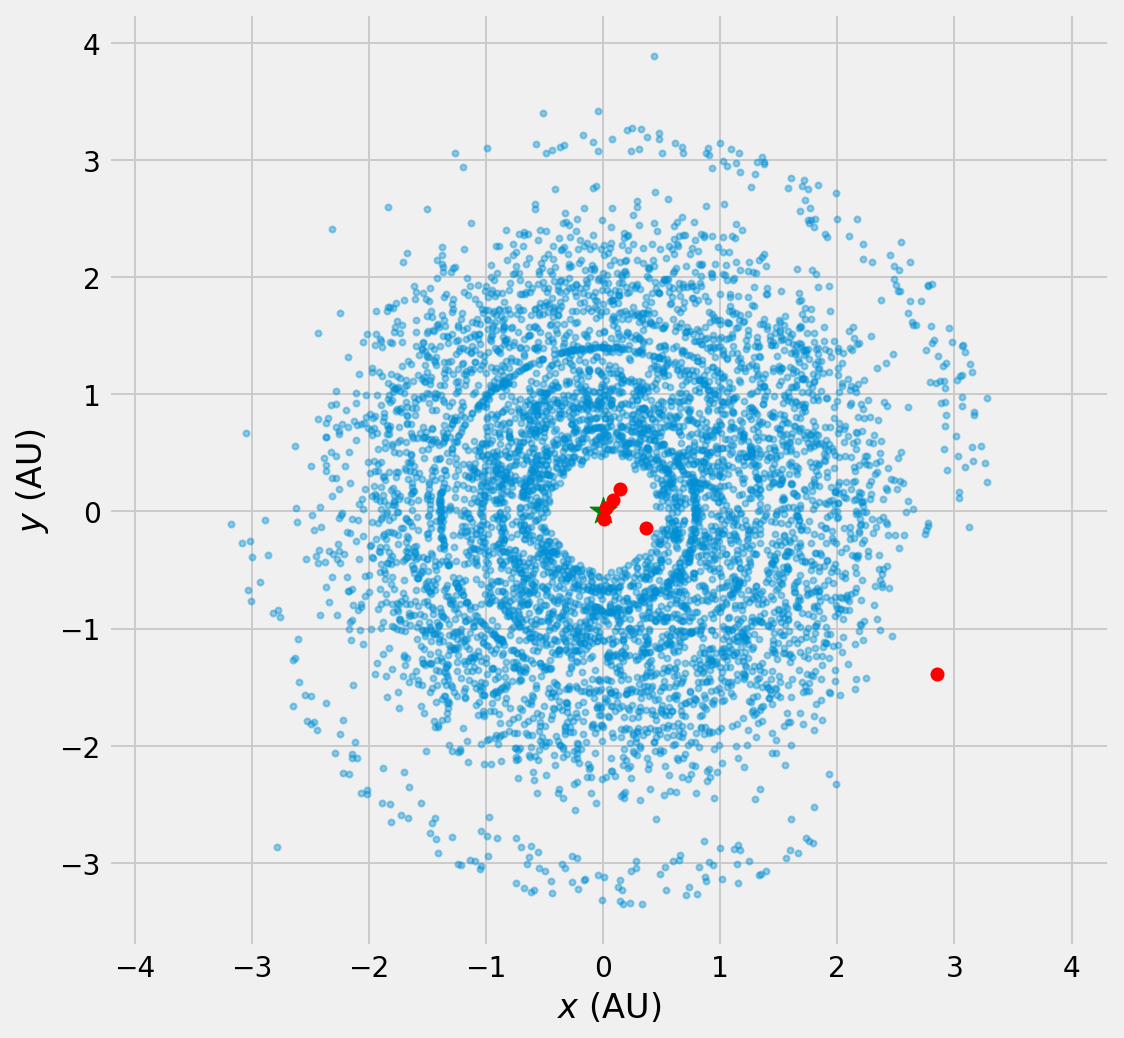

In [19]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(8, 8))
    plt.plot(parts.x[idx], parts.y[idx], '.', alpha=0.4)
    plt.plot(parts.x[:6], parts.y[:6], 'or')
    plt.scatter(0, 0, s=200, marker='*', c='green')
    # plt.title('Position of Test Particles at $t = 1000$ Days')
    plt.xlabel('$x$ (AU)')
    plt.ylabel('$y$ (AU)')
    plt.axis('equal')
    plt.show()

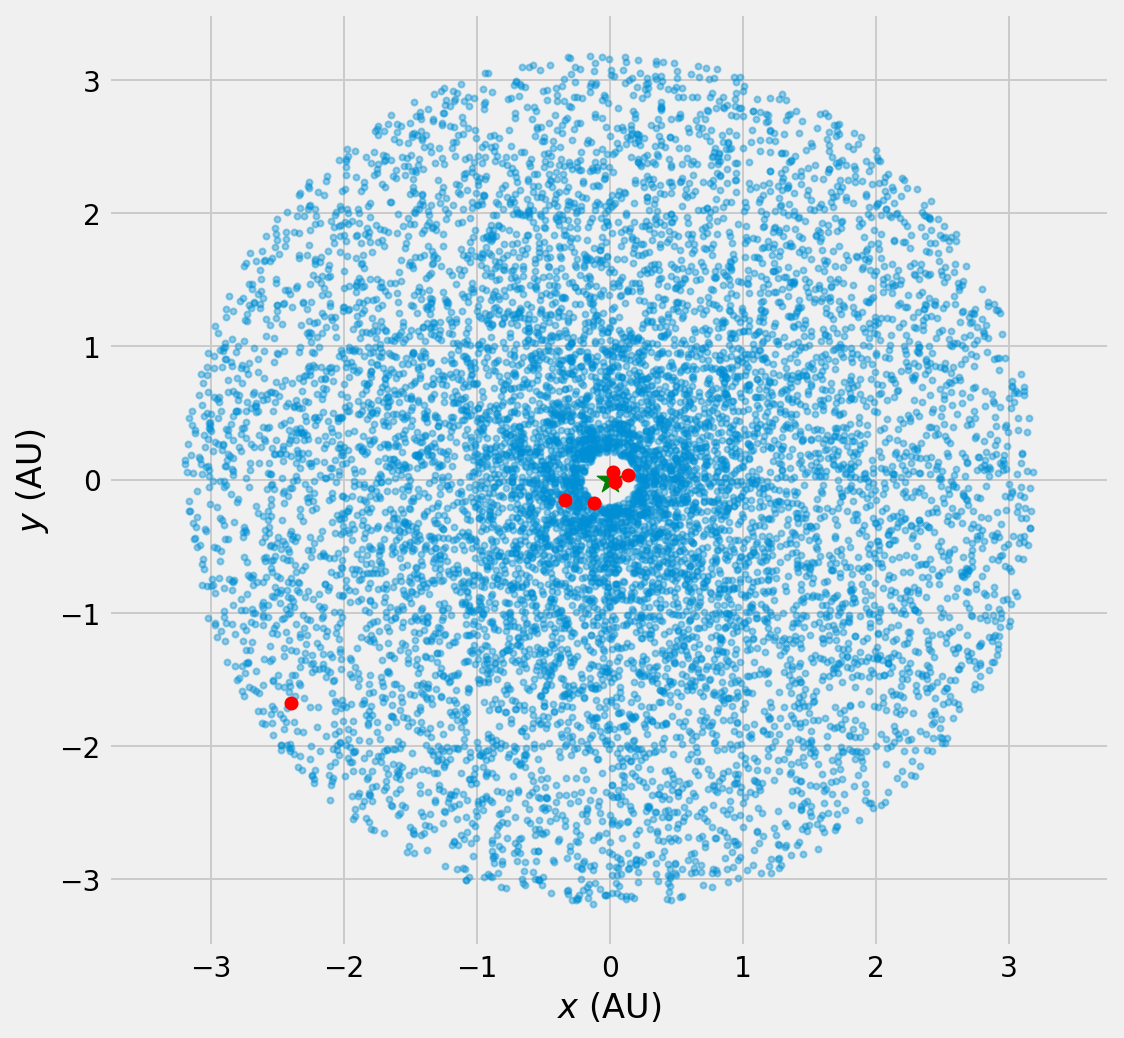

In [15]:
sim = sims[0]
particles = sim.particles
parts_init = pd.DataFrame(np.array([[p.hash.value, p.x, p.y, p.z, p.e] for p in particles[1:]]), columns=['id', 'x', 'y', 'z', 'e'])
idx = (np.abs(parts_init.x) < 5) & (np.abs(parts_init.y) < 5) 

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(8, 8))
    plt.plot(parts_init.x[idx], parts_init.y[idx], '.', alpha=0.4)
    plt.plot(parts_init.x[:6], parts_init.y[:6], 'or')
    plt.scatter(0, 0, s=200, marker='*', c='green')
    # plt.title('Position of Test Particles at $t = 1000$ Days')
    plt.xlabel('$x$ (AU)')
    plt.ylabel('$y$ (AU)')
    plt.axis('equal')
    plt.show()

## Orbital Elements
 - Inclination
 - Semi-Major Axis
 - Eccentricity

In [21]:
sim = sims[-1]
sim.integrator_synchronize()
orbits = sim.calculate_orbits()

In [22]:
elements = pd.DataFrame([(p.a, p.e, p.inc) for p in orbits[num_planets:]], columns=('a', 'e', 'inc'))

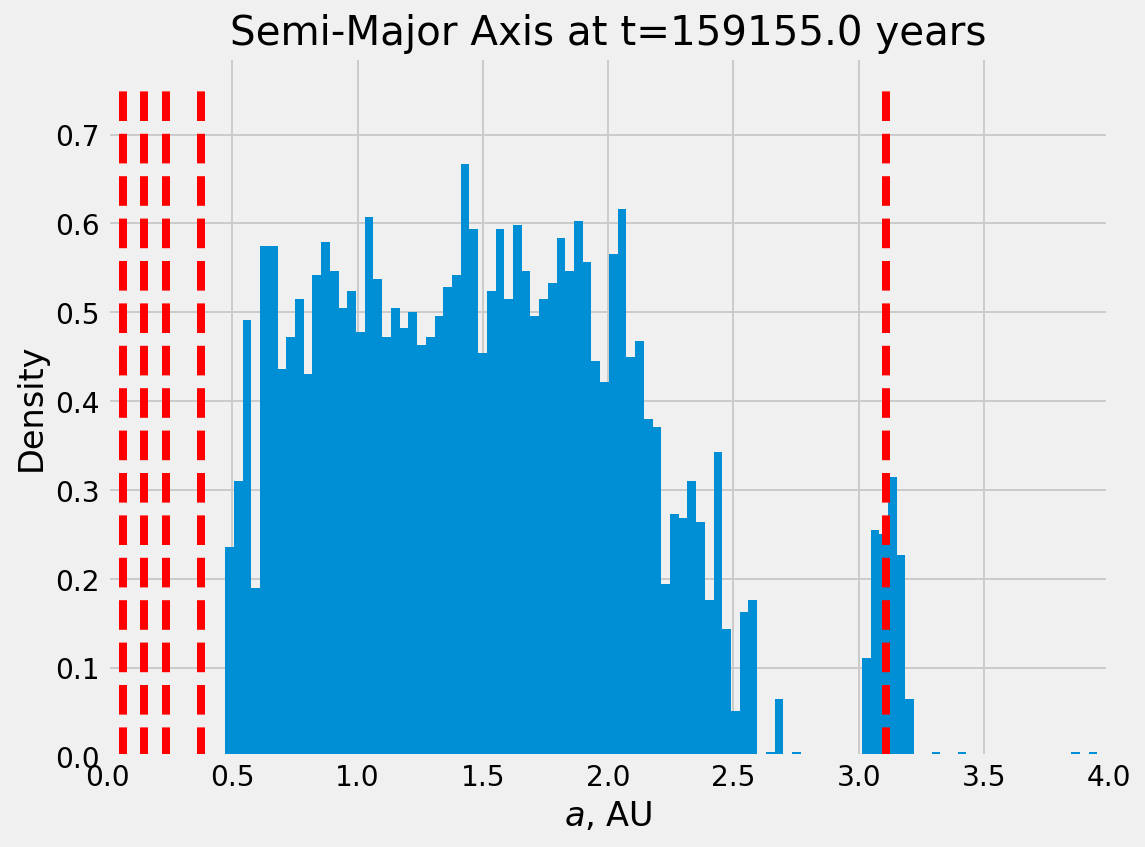

In [24]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(8,6))
    plt.title('Semi-Major Axis at t={} years'.format(round(t[-1])))
    plt.xlabel('$a$, AU')
    plt.ylabel('Density')
    plt.xlim([0,4])

    for i, p in enumerate(orbits[1:num_planets]):
        plt.plot([p.a, p.a], [0, 0.75], 'r--', label='Planet {}'.format(planets.pl_letter[i]))

    plt.hist(elements.a[(elements.a > 0) & (elements.a < 4) & (elements.e < 0.1)], bins=100, density=True)
    plt.show()

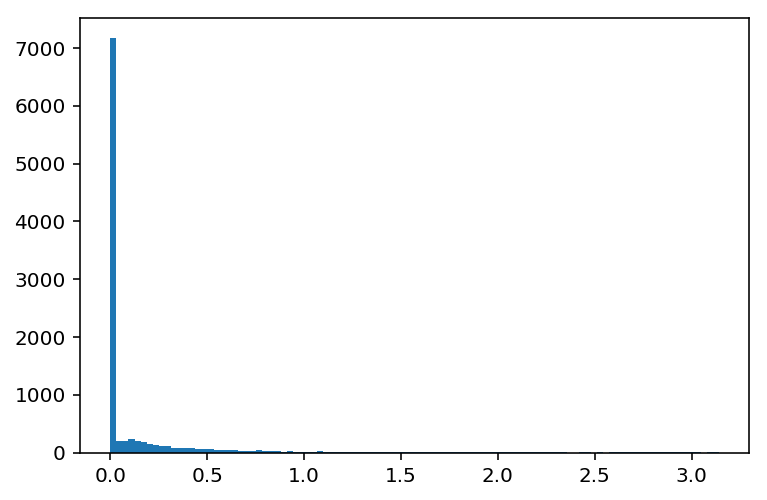

In [29]:
plt.hist(elements.inc, bins=100)
plt.show()

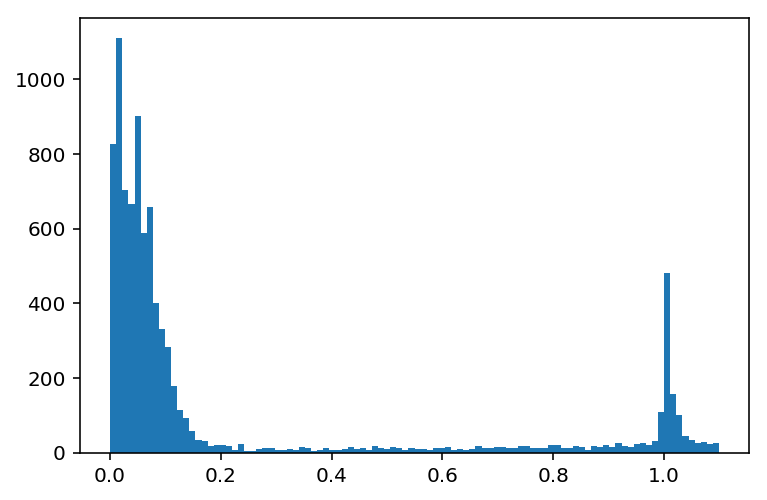

In [30]:
plt.hist(elements.e[elements.e < 1.1], bins=100)
plt.show()

## Conserved Quantities

In [31]:
energy = np.array([s.calculate_energy() for s in sims])
ang_mom = np.sqrt(np.sum(np.array([s.calculate_angular_momentum() for s in sims]) ** 2, axis=1))

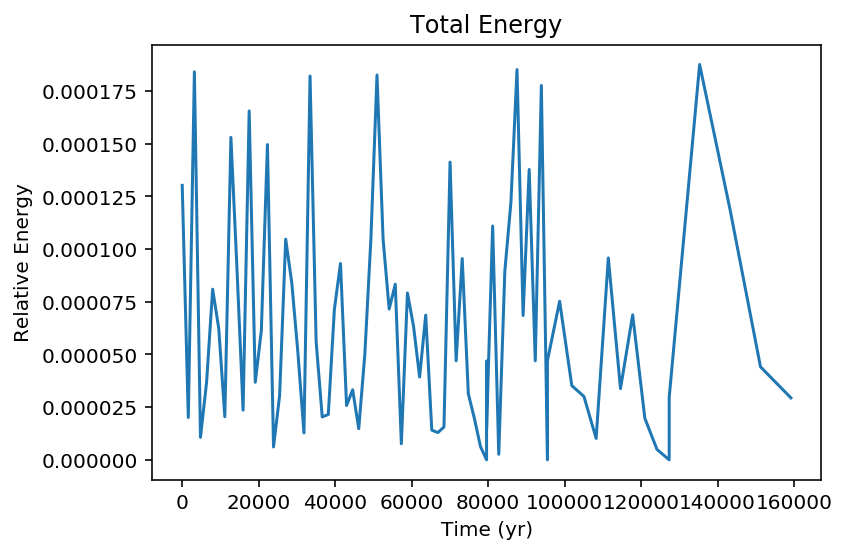

In [32]:
plt.plot(t, np.abs(energy / np.roll(energy, -1) - 1))
plt.title('Total Energy')
plt.xlabel('Time (yr)')
plt.ylabel('Relative Energy')
plt.show()

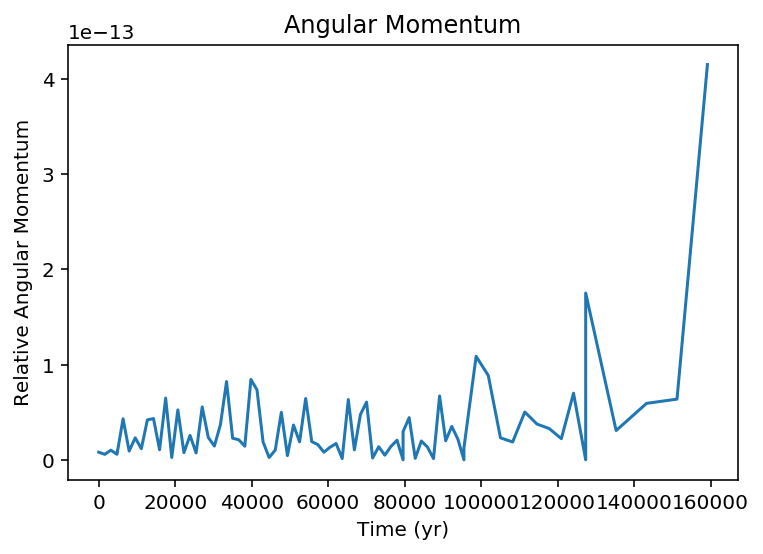

In [33]:
plt.plot(t, np.abs(ang_mom / np.roll(ang_mom, -1) - 1))
plt.title('Angular Momentum')
plt.xlabel('Time (yr)')
plt.ylabel('Relative Angular Momentum')
plt.show()